<a href="https://colab.research.google.com/github/aleve34/Deepfakes_Detection/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "alevealeve",\r\n  "key": "KGAT_eb1715ef0f1e09b6ef097959c701c8e8"\r\n}\r\n'}

In [2]:
!pip install kaggle  # Only first time
!mkdir ~/.kaggle
# Upload kaggle.json (API key) in Colab, or use your local one
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d fatimahirshad/faceforensics-extracted-dataset-c23
!unzip -q faceforensics-extracted-dataset-c23.zip -d /content/
DATA_ROOT = "/content/FF++C32-Frames"


Dataset URL: https://www.kaggle.com/datasets/fatimahirshad/faceforensics-extracted-dataset-c23
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 3.78G/3.78G [00:49<00:00, 41.5MB/s]
100% 3.78G/3.78G [00:49<00:00, 82.5MB/s]


Using device: cuda
Original: 5000 | Deepfakes: 5000
TRAIN: 7000, VAL: 1500, TEST: 1500
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Trainable parameters: 5271634

Epoch 1/20
  Train Loss: 0.6201 | Train Acc: 0.6274
  Val   Acc: 0.7533
  → New best model saved (Val Acc: 0.7533)

Epoch 2/20
  Train Loss: 0.4338 | Train Acc: 0.7884
  Val   Acc: 0.7813
  → New best model saved (Val Acc: 0.7813)

Epoch 3/20
  Train Loss: 0.3291 | Train Acc: 0.8490
  Val   Acc: 0.8207
  → New best model saved (Val Acc: 0.8207)

Epoch 4/20
  Train Loss: 0.2479 | Train Acc: 0.8917
  Val   Acc: 0.8427
  → New best model saved (Val Acc: 0.8427)

Epoch 5/20
  Train Loss: 0.2133 | Train Acc: 0.9070
  Val   Acc: 0.8513
  → New best model saved (Val Acc: 0.8513)

Epoch 6/20
  Train Loss: 0.1379 | Train Acc: 0.9424
  Val   Acc: 0.8827
  → New best model saved (Val Acc: 0.8827)

Epoch 7

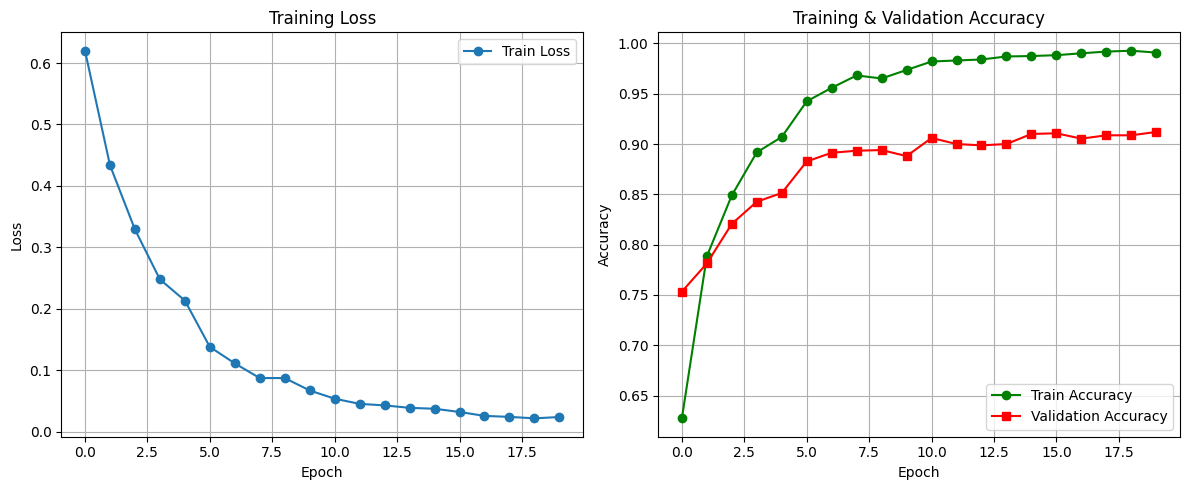

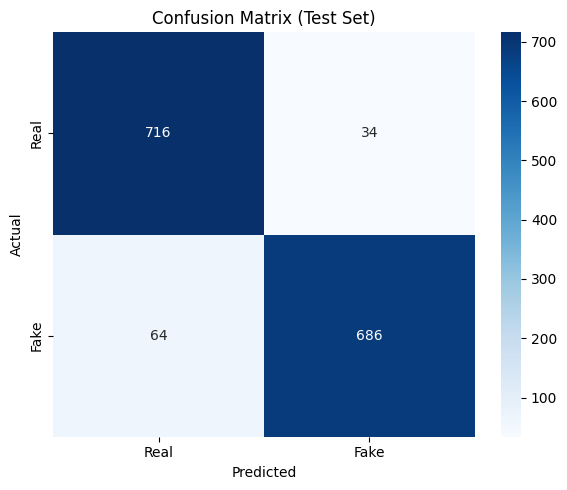

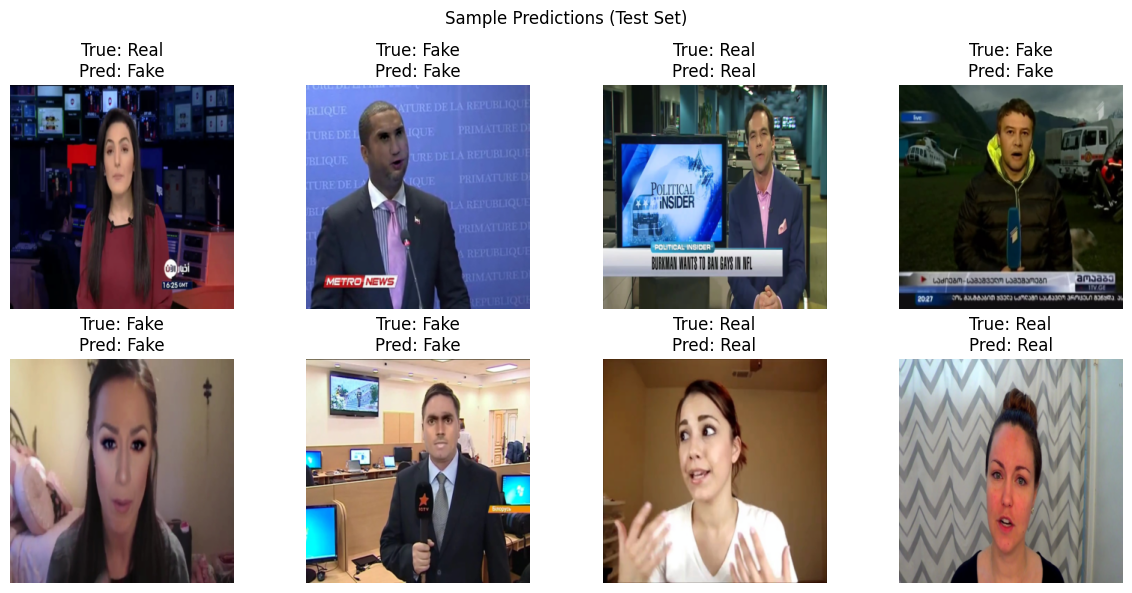

Best model saved as 'xception_finetuned_best.pth'


In [4]:
# -----------------------------
#  DEEPFAKE DETECTION WITH XCEPTION 
# -----------------------------

import os
import random
from glob import glob
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import timm
from torch.optim.lr_scheduler import StepLR

# -----------------------------
#  CONFIG
# -----------------------------
DATA_ROOT = r"/content/FF++C32-Frames"
IMG_SIZE = 299
BATCH_SIZE = 16
RANDOM_SEED = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15
EPOCHS = 20
LR = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -----------------------------
#  TRANSFORMS
# -----------------------------
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# -----------------------------
#  DATA LOADING
# -----------------------------
original_images = glob(os.path.join(DATA_ROOT, "Original", "*.jpg"))
deepfake_images = glob(os.path.join(DATA_ROOT, "Deepfakes", "*.jpg"))

print(f"Original: {len(original_images)} | Deepfakes: {len(deepfake_images)}")

images = original_images + deepfake_images
labels = [0] * len(original_images) + [1] * len(deepfake_images)

# Shuffle
combined = list(zip(images, labels))
random.shuffle(combined)
images, labels = zip(*combined)

# Stratified split
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    images, labels, test_size=(TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_SEED, stratify=labels
)
val_ratio = VAL_SIZE / (TEST_SIZE + VAL_SIZE)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=1 - val_ratio,
    random_state=RANDOM_SEED, stratify=temp_labels
)

print(f"TRAIN: {len(train_imgs)}, VAL: {len(val_imgs)}, TEST: {len(test_imgs)}")

# -----------------------------
#  CUSTOM DATASET
# -----------------------------
class SimpleFaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SimpleFaceDataset(train_imgs, train_labels, transform_train)
val_dataset = SimpleFaceDataset(val_imgs, val_labels, transform_test)
test_dataset = SimpleFaceDataset(test_imgs, test_labels, transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# -----------------------------
#  MODEL (XCEPTION)
# -----------------------------
model = timm.create_model('xception', pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Unfreeze last 5 blocks + classifier
blocks_to_unfreeze = ["block10", "block11", "block12", "block13", "block14", "fc"]
for name, param in model.named_parameters():
    param.requires_grad = any(block in name for block in blocks_to_unfreeze)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model = model.to(device)

# -----------------------------
#  LOSS, OPTIMIZER, SCHEDULER
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# -----------------------------
#  TRAINING & EVALUATION FUNCTIONS
# -----------------------------
train_losses = []
train_accuracies = []
val_accuracies = []

def train_one_epoch():
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(train_loader), correct / total

def evaluate(loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    acc = np.mean(np.array(all_labels) == np.array(all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"], digits=4)
    return acc, cm, report

# -----------------------------
#  TRAINING LOOP WITH EARLY STOPPING
# -----------------------------
best_val_acc = 0.0
patience = 5
trigger_times = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch()
    val_acc, val_cm, val_report = evaluate(val_loader)

    # Track metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "xception_finetuned_best.pth")
        trigger_times = 0
        print(f"  → New best model saved (Val Acc: {val_acc:.4f})")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"  → Early stopping triggered after {patience} epochs without improvement.")
            break

    scheduler.step()

# -----------------------------
#  FINAL TEST EVALUATION
# -----------------------------
model.load_state_dict(torch.load("xception_finetuned_best.pth", map_location=device))
test_acc, test_cm, test_report = evaluate(test_loader)

print("\n" + "="*50)
print("          FINAL TEST RESULTS (BEST MODEL)")
print("="*50)
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", test_report)

# -----------------------------
#  VISUAL RESULTS FOR PRESENTATION
# -----------------------------

# Learning curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s', color='red')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# Sample predictions
model.eval()
sample_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(sample_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = images[i].permute(1,2,0).numpy()
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"True: {'Real' if labels[i]==0 else 'Fake'}\nPred: {'Real' if preds[i]==0 else 'Fake'}")
    plt.axis('off')
plt.suptitle("Sample Predictions (Test Set)")
plt.tight_layout()
plt.show()

print("Best model saved as 'xception_finetuned_best.pth'")


# Presentation: Deepfake Detection with XceptionNet

## 1. Introduction
- Goal: Detect whether an image extracted from a video is **real or fake**.  
- Method: Fine-tuning **XceptionNet** on the FaceForensics++ dataset.  
- Challenge: Deepfakes are increasingly realistic, making detection difficult.

---

## 2. Dataset
- **Source:** [FaceForensics++ C23 Dataset](https://www.kaggle.com/datasets/fatimahirshad/faceforensics-extracted-dataset-c23)  
- **Total folders:** 6 (Original, Deepfakes, FaceSwap, NeuralTextures, DeepfakesCompression, others)  
- **Folders used:** `Original` and `Deepfakes` only  
- **Details:**  
  - Images of size 299×299 pixels  
  - ~5000 real and ~5000 fake images  
  - Images are **full frames**   
- **Preprocessing:** Minimal (random horizontal flip only)

---

## 3. Model: XceptionNet

- **Reference:** FaceForensics++ 2019 — considered the **best performing model** for deepfake detection.  
- **Architecture:**  
  - Depthwise separable convolutions  
  - Entry → Middle → Exit flows  
  - Global average pooling + Fully connected layer for binary classification  
- **Pre-trained:** ImageNet  
- **Fine-tuning:** Last blocks + classifier

**Summary :**  
> “We chose XceptionNet because it can detect subtle visual artifacts in deepfake videos and achieves high accuracy even on full frames.”

---

## 4. Training

- Optimizer: Adam (adaptive learning rate, efficient for fine-tuning)
- Loss function: Cross-Entropy (suitable for binary classification)
- Batch size: 16
- Epochs: 20, with early stopping to prevent overfitting
- Learning rate schedule: StepLR with gamma = 0.5 every 5 epochs
- Preprocessing / Augmentation: Minimal — only random horizontal flip

## Fine-tuning strategy:

- Initialized with ImageNet pre-trained weights
- Last blocks + classifier layers were trainable
- Early layers were frozen to preserve learned low-level features

## Training Observations:

- Training loss decreases steadily over epochs → model is learning effectively
- Training accuracy reaches ~99%, validation accuracy ~91% → slight gap, minimal overfitting
- Early stopping helps avoid wasting epochs once validation stops improving

## Key Point:

> "Fine-tuning XceptionNet on full-frame images with minimal augmentation yields robust detection performance while keeping training efficient."

---

## 5. Results

### Model Performance
- **Validation Accuracy:** 91.2%  
- **Test Accuracy:** 93.47%  
  - This shows the model generalizes well on unseen test frames.
- **Precision, Recall, F1-score:**  
  - **Real frames:** Precision 91.8%, Recall 95.5%, F1-score 93.6%  
  - **Fake frames:** Precision 95.3%, Recall 91.5%, F1-score 93.3%  
  - Balanced performance: the model detects real and fake frames almost equally well.

### Confusion Matrix
- The confusion matrix shows the model’s predictions on the test set:
  
| Actual \ Predicted | Real | Fake |
|------------------|------|------|
| Real             | 716  | 34   |
| Fake             | 64   | 686  |

**Interpretation:**
- **True Positives (Real correctly predicted):** 716  
- **False Negatives (Real predicted as Fake):** 34  
- **False Positives (Fake predicted as Real):** 64  
- **True Negatives (Fake correctly predicted):** 686  

**Key points to highlight:**
- The model performs **very well** on both classes.  
- Slightly more **Fake frames misclassified as Real** than Real misclassified as Fake (64 vs 34), but overall balanced.  
- This confirms the **93.47% test accuracy** reported.  


### Training Curves
- **Loss curve:** decreases steadily over epochs, indicating good learning.  
- **Accuracy curve:** training accuracy reaches ~99%, validation accuracy ~91%.  
- Small gap between training and validation accuracy → minimal overfitting, fine-tuning was effective.

### Example Predictions
- Random sample images from test set:  
  - Real frames correctly predicted as real  
  - Fake frames correctly predicted as fake  
- Helps visually confirm that the model is detecting subtle artifacts in fake frames.

---

## 6. Challenges in Deepfake Detection
- Deepfakes are very realistic → hard to detect
- Compression or editing removes subtle artifacts
- Models may fail on new/unseen deepfake types
- Deep learning models are “black boxes”
- Real-time detection can be slow

## 7. Solutions / Insights from Research
- Train on diverse data (compressed, noisy, post-processed)
- Analyze video sequences for inconsistencies
- Combine multiple detection methods
- Update models regularly to handle new attacks

## 8. Implications for Our Project
- XceptionNet works well on our dataset
- May be less accurate on real-world videos
- Can improve by adding noisy/compressed images, cropping faces, or combining methods

---
**Key takeaway:**  
- XceptionNet performs very well for binary classification of deepfakes on full-frame images.  
- Performance could be further improved by using cropped faces, more augmentation, or a larger dataset.  
- Detecting deepfakes remains challenging for more subtle or unseen attack types.